In [533]:

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
from arch import arch_model
from scipy.stats import norm
import scipy.stats
import pylab
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error

## Loading and Transforming the Data

### Prices

In [534]:
raw_csv_data = pd.read_csv("/Users/mcardonasanchez/Desktop/Online Courses/Time-Series-Analysis-in-Python/Section-3/Index2018.csv")
df_comp = raw_csv_data.copy()
print(df_comp.head(10))
print("Shape: " + str(df_comp.shape))
print("Columns: " + str(df_comp.columns))

         date     spx      dax     ftse    nikkei
0  07/01/1994  469.90  2224.95  3445.98  18124.01
1  10/01/1994  475.27  2225.00  3440.58  18443.44
2  11/01/1994  474.13  2228.10  3413.77  18485.25
3  12/01/1994  474.17  2182.06  3372.02  18793.88
4  13/01/1994  472.47  2142.37  3360.01  18577.26
5  14/01/1994  474.91  2151.05  3400.56  18973.70
6  17/01/1994  473.30  2115.56  3407.83  18725.37
7  18/01/1994  474.25  2130.35  3437.01  18514.55
8  19/01/1994  474.30  2132.52  3475.15  19039.40
9  20/01/1994  474.98  2098.36  3469.99  19183.92
Shape: (6269, 5)
Columns: Index(['date', 'spx', 'dax', 'ftse', 'nikkei'], dtype='object')


In [535]:
df_comp['market_value'] = df_comp.ftse

df_comp.date = pd.to_datetime(df_comp.date, dayfirst=True)
df_comp.set_index('date', inplace=True)
df_comp.asfreq('b', 'ffill')
df_comp['market_value']

date
1994-01-07    3445.980000
1994-01-10    3440.580000
1994-01-11    3413.770000
1994-01-12    3372.020000
1994-01-13    3360.010000
                 ...     
2018-01-23    7731.827774
2018-01-24    7643.428966
2018-01-25    7615.839954
2018-01-26    7665.541292
2018-01-29    7671.533300
Name: market_value, Length: 6269, dtype: float64

### Visualising the Data

<AxesSubplot: title={'center': 'FTSE prices'}, xlabel='date'>

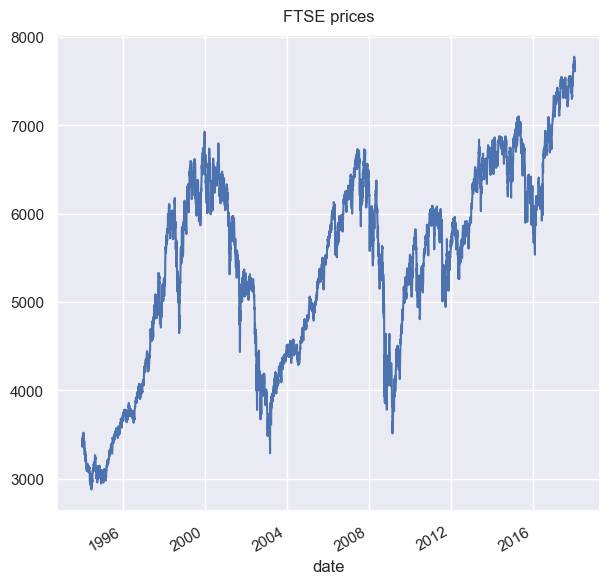

In [536]:
df_comp['market_value'].plot(title='FTSE prices')

<AxesSubplot: title={'center': 'FTSE cumulative sum'}, xlabel='date'>

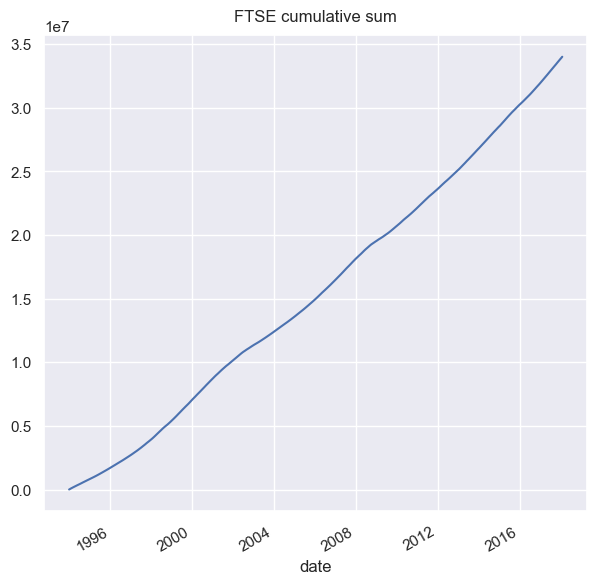

In [537]:
df_comp.market_value.cumsum().plot(title='FTSE cumulative sum')

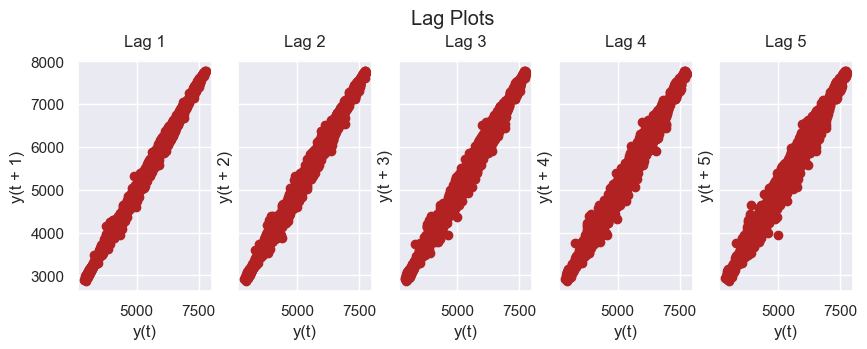

In [538]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(1, 5, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:5]):
    lag_plot(df_comp.market_value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots', y=1.05)    
plt.show()

A time series is also regarded to include three systematic components: level, trend, and seasonality, as well as one non-systematic component termed noise.

The following are the components’ definitions:
- The average value in the series is called the level.
- The increasing or falling value in the series is referred to as the trend.
- Seasonality is the series’ recurring short-term cycle.
- The random variance in the series is referred to as noise.

#### Rolling Statistics

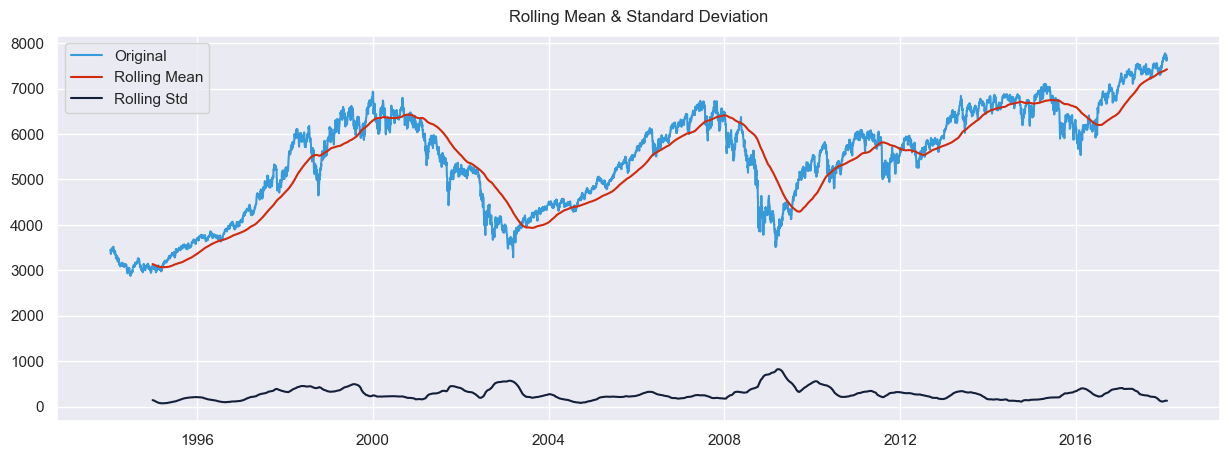

In [539]:
# Determine rolling statistics
#window size 252 denotes 1 year (252 business days), giving rolling mean at yearly level
df_comp['rolling_avg'] = df_comp['market_value'].rolling(window=252).mean()
df_comp['rolling_std'] = df_comp['market_value'].rolling(window=252).std()

# Plot rolling statistics
plt.figure(figsize=(15,5))
plt.plot(df_comp['market_value'],color='#379BDB', label='Original')
plt.plot(df_comp["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df_comp["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

#### Seasonality and trend

Any time series may be split into the following components: Base Level + Trend + Seasonality + Error\
A trend is observed when there is an increasing or decreasing slope observed in the time series. Whereas seasonality is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors. 

Additive time series:\
Value = Base Level + Trend + Seasonality + Error

Multiplicative Time Series:\
Value = Base Level x Trend x Seasonality x Error

In [540]:
# Multiplicative Decomposition
result_mult = seasonal_decompose(df_comp['market_value'], model='multiplicative', extrapolate_trend='freq')

# Aditive Decomposition
result_add = seasonal_decompose(df_comp['market_value'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (7,7)})
result_mult.plot().suptitle('Multiplicative Decompose', fontsize=8)
result_add.plot().suptitle('Additive Decompose', fontsize=8)
plt.show()

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

#### Augmented Dickey-Fuller Test

The Augmented Dickey-Fuller Test is used to determine if time-series data is stationary or not.\
For the data to be stationary (ie. reject the null hypothesis), the ADF test should have:\
p-value <= significance level (0.01, 0.05, 0.10, etc.)\
If the p-value is greater than the significance level then we can say that it is likely that the data is not stationary.

In [541]:
# Augmented Dickey-Fuller test
print('Results of Dickey Fuller Test:')
df_ad_test = adfuller(df_comp.market_value, autolag='AIC')

dfoutput = pd.Series(df_ad_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

for key, value in df_ad_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)
if dfoutput[1]<0.05:
    print('p-value is %s, meaning that there is enough evidence to say the data is stationary'%dfoutput[1])
else:
    print('p-value is %s, meaning that there is NOT enough evidence to say the data is stationary'%dfoutput[1])

Results of Dickey Fuller Test:
Test Statistic                   -1.594282
p-value                           0.486465
#Lags Used                        6.000000
Number of Observations Used    6262.000000
Critical Value (1%)              -3.431395
Critical Value (5%)              -2.862002
Critical Value (10%)             -2.567016
dtype: float64
p-value is 0.4864651302056871, meaning that there is NOT enough evidence to say the data is stationary


#### ACF and PACF

ACF shows direct and indirect effect of past lags. Estimating MA components.

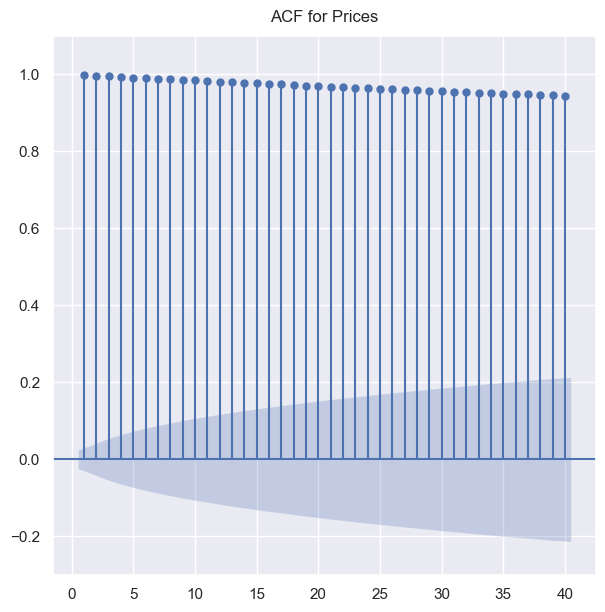

In [542]:
sgt.plot_acf(df_comp.market_value, zero=False, lags=40)
plt.title('ACF for Prices')
plt.ylim([-0.3, 1.1])
plt.show()

PACF shows only direct effect of past lags. Estimating AR components/

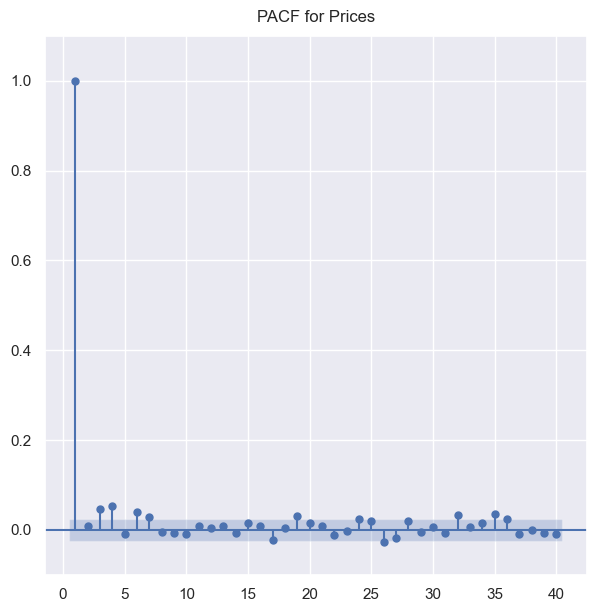

In [543]:
sgt.plot_pacf(df_comp.market_value, lags=40, alpha = 0.05, zero=False, method=('ols'))
plt.title('PACF for Prices')
plt.ylim([-0.1,1.1])
plt.show()

#### QQ-Plot

If data follows the red line it means it is normally distributed - stock data usually isn't

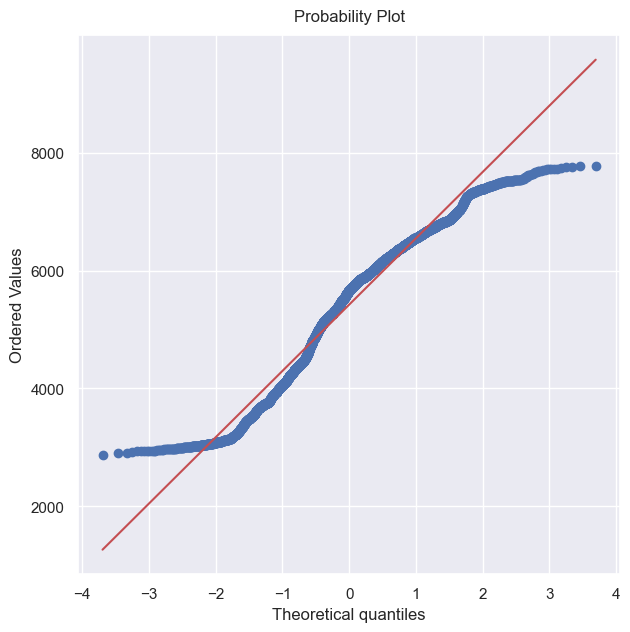

In [544]:
scipy.stats.probplot(df_comp.market_value, plot=pylab)
pylab.show()

### Returns

In [545]:
df_comp['returns'] = df_comp.market_value.apply(np.log) - df_comp.market_value.shift(1).apply(np.log)
df = df_comp.iloc[1:]

In [546]:
df_comp['returns'] = df_comp.market_value.apply(np.log) - df_comp.market_value.shift(1).apply(np.log)

df_comp['ret_ftse'] = df_comp.ftse.apply(np.log) - df_comp.ftse.shift(1).apply(np.log)
df_comp['ret_nikkei'] = df_comp.nikkei.apply(np.log) - df_comp.nikkei.shift(1).apply(np.log)
df_comp['ret_spx'] = df_comp.spx.apply(np.log) - df_comp.spx.shift(1).apply(np.log)
df_comp['ret_dax'] = df_comp.dax.apply(np.log) - df_comp.dax.shift(1).apply(np.log)

df = df_comp.iloc[1:]

#### Rolling Statistics

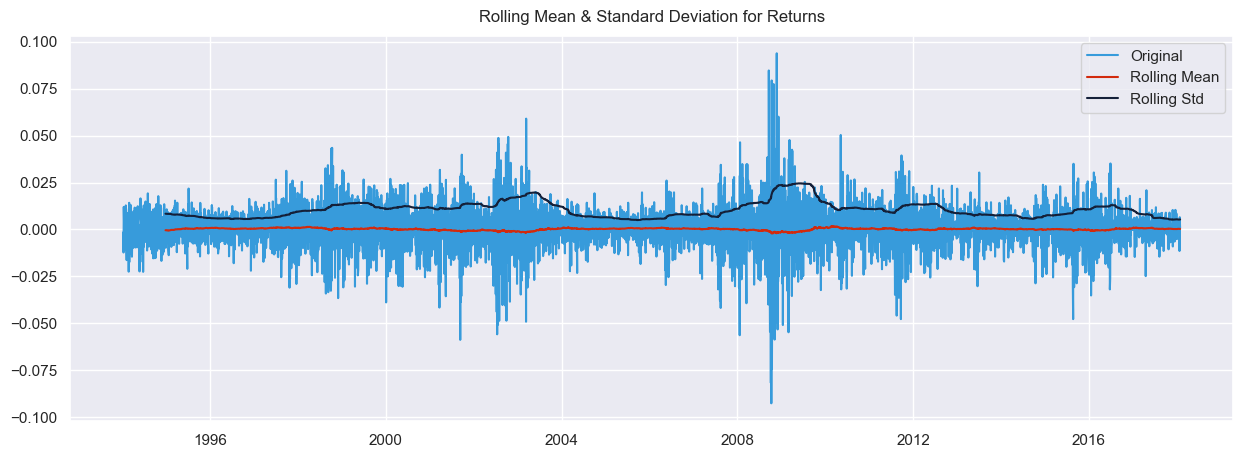

In [547]:
# Determine rolling statistics
#window size 252 denotes 1 year (252 business days), giving rolling mean at yearly level
df['rolling_avg_ret'] = df['returns'].rolling(window=252).mean()
df['rolling_std_ret'] = df['returns'].rolling(window=252).std()

# Plot rolling statistics
plt.figure(figsize=(15,5))
plt.plot(df['returns'],color='#379BDB', label='Original')
plt.plot(df["rolling_avg_ret"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std_ret"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation for Returns')
plt.show(block=False)

#### Augmented Dickey-Fuller Test

In [548]:
# Augmented Dickey-Fuller test
print('Results of Dickey Fuller Test:')
df_ad_test = adfuller(df.returns, autolag='AIC')

dfoutput = pd.Series(df_ad_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

for key, value in df_ad_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)
if dfoutput[1]<0.05:
    print('p-value is %s, meaning that there is enough evidence to say the data is stationary'%dfoutput[1])
else:
    print('p-value is %s, meaning that there is NOT enough evidence to say the data is stationary'%dfoutput[1])

Results of Dickey Fuller Test:
Test Statistic                -1.496700e+01
p-value                        1.215837e-27
#Lags Used                     3.400000e+01
Number of Observations Used    6.233000e+03
Critical Value (1%)           -3.431400e+00
Critical Value (5%)           -2.862004e+00
Critical Value (10%)          -2.567017e+00
dtype: float64
p-value is 1.2158371752155353e-27, meaning that there is enough evidence to say the data is stationary


#### ACF and PACF for Returns

First several lags of great important - signficant but negative coefficient (some form of natual adjustment occurring in the market).\
Today's prices move in the opposite direction of prices yesterday, price increases following price decreases.\
For AR look into models of order 6 or 8.

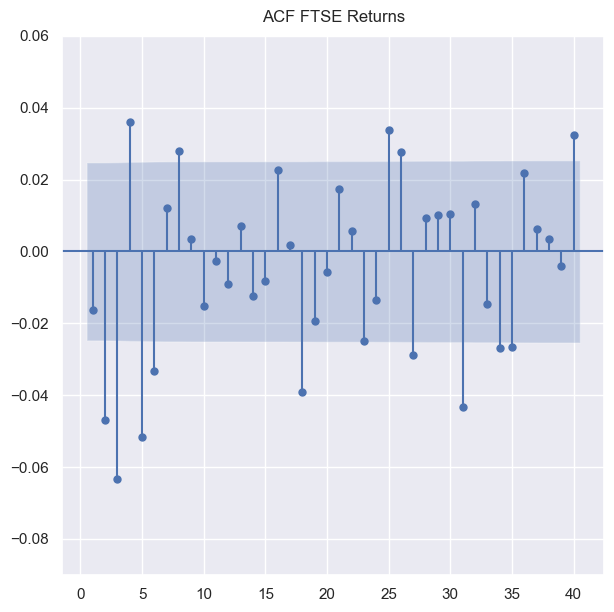

In [550]:
sgt.plot_acf(df.returns, lags=40, zero=False)
plt.title('ACF FTSE Returns')
plt.ylim(-0.09,0.06)
plt.show()

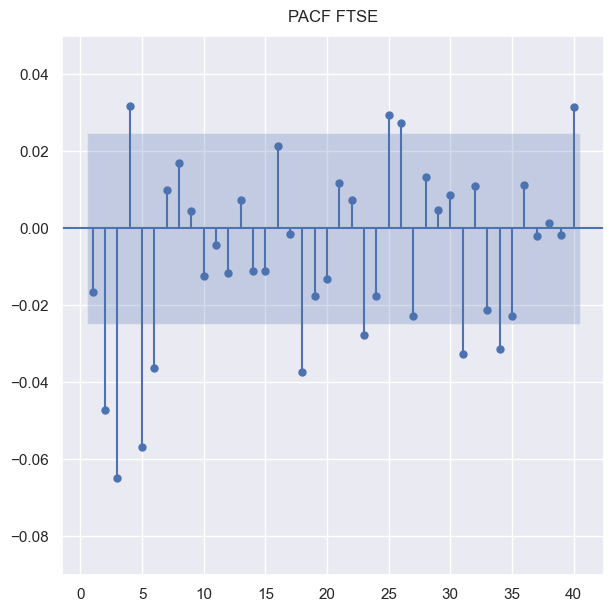

In [551]:
sgt.plot_pacf(df.returns, lags=40, zero=False, method=('ols'))
plt.title('PACF FTSE')
plt.ylim(-0.09,0.05)
plt.show()

#### QQ-Plot

If data follows the red line it means it is normally distributed - stock data usually isn't

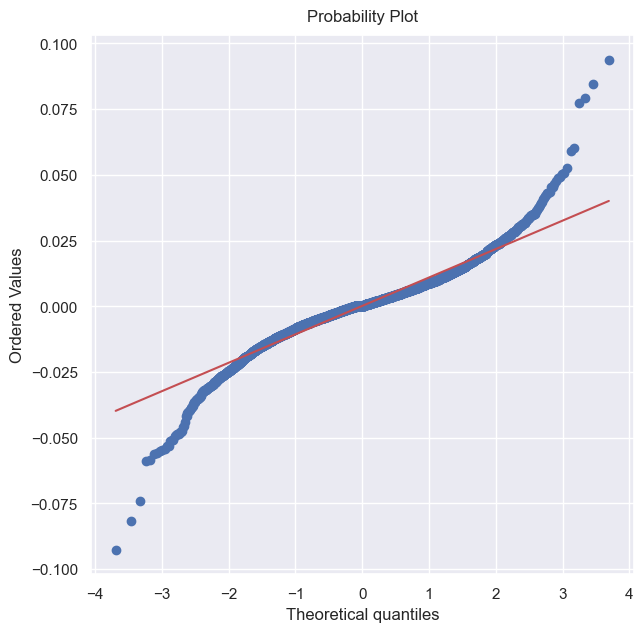

In [552]:
scipy.stats.probplot(df.returns, plot=pylab)
pylab.show()

Mean Return: 0.00012768158421777945, Volatility: 0.00012500136227626977


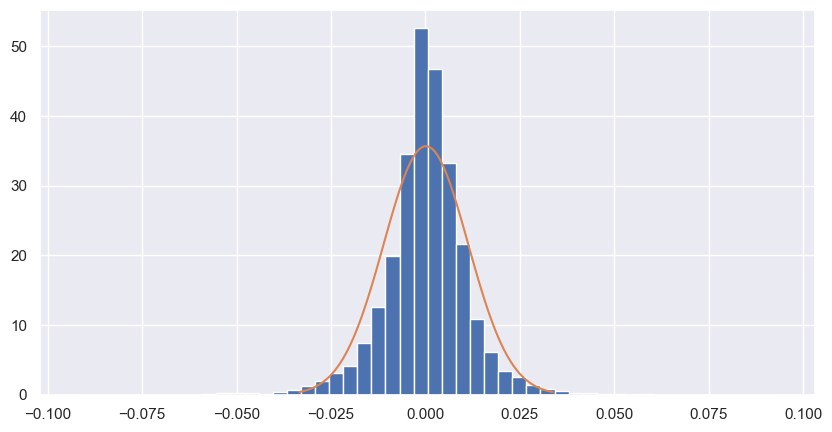

In [553]:
fig, ax = plt.subplots(figsize=(10,5))
plt.hist(df.returns, bins=50, density=True)

mean_return = np.mean(df.returns)
volatility = np.var(df.returns)
print("Mean Return: " + str(mean_return) + ", Volatility: " + str(volatility))
std_dev = np.sqrt(volatility)


x_axis = np.linspace(mean_return - 3*std_dev,mean_return+3*std_dev, 100)
plt.plot(x_axis, norm.pdf(x_axis,mean_return,std_dev))
plt.show()

### VAR

In [554]:
from scipy.stats import norm
conf_level1 = 0.05
var_95 = norm.ppf(conf_level1, mean_return, std_dev)
print(var_95)
print(np.exp(var_95))

-0.018262441239177696
0.9819033066203068


## Split data into train and test

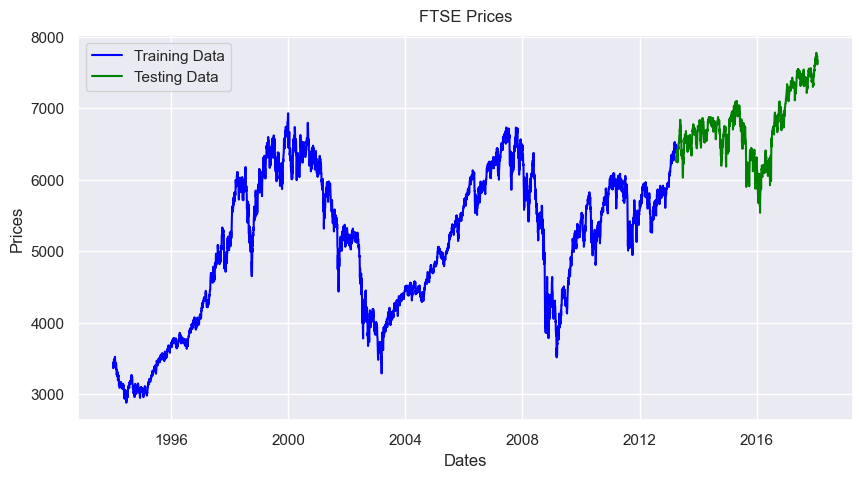

In [556]:
# Split into train and test
size = int(len(df)*0.8)
df_train, df_test = df.iloc[:size], df.iloc[size:]
plt.figure(figsize=(10,5))
plt.title('FTSE Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_train.market_value, 'blue', label='Training Data')
plt.plot(df_test.market_value, 'green', label='Testing Data')
plt.legend()

## Modelling

To Pick a Model
1. Significant coefficients (not zero, P(z) significant <0.05 - else no predictive power)
2. Parsimomious (as simple as possible) -> LLR
3. Residuals should resemble white noise  -> there isn't a pattern we haven't accounted for
4. Absolute value of coefficients should be less than 1

#### Model Diagnostics

We can interpret the model as a good fit based on the following conditions.

1. Standardized residual\
There are no obvious patterns in the residuals, with values having a mean of zero and having a uniform variance.

2. Histogram plus KDE estimate\
The KDE curve should be very similar to the normal distribution (labeled as N(0,1) in the plot)

3. Normal Q-Q\
Most of the data points should lie on the straight line

4. Correlogram (ACF plot)\
95% of correlations for lag greater than zero should not be significant. The grey area is the confidence band, and if values fall outside of this then they are statistically significant. In our case, there are a few values outside of this area, and therefore we may need to add more predictors to make the model more accurate

### LLR Test

We want a model with higher log-likelihood and lower information criteria (AIC).\
LLR test determines if two models are significantly different - i.e. log-likelihood is significantly greater.\
LLR(model1, model2) < 0.05, model 2 is better.\
Simple model (less coefficients) first.\
For either AR, MA, or nested ARMA/ARIMA.

In [557]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

### ARIMA

- AR and MA models not good for non-stationary data.
    - AR: failed to adjust quickly to unexpected shocks, accounts only for past values.
    - MA: smooths out predictions, taking into account residuals.


- ARIMA: better for modelling non-stationary data - e.g. returns ().\
Estimates jumpts between prices. A simgle factor of integration is enough to reach stationarity - returns are slightly different.
Repeat for prices and returns and follow these steps for every model. To check integration, integrate .diff(integration_order) and AD-Fuller test to check stationary.

For ARMA and ARIMA examine ACF of residuals. If ACF fails, plot from second element onwards.


In [ ]:
# exogenous -> outside factors (e.g other time series)
# m -> seasonal cycle length
# max_order -> maximum amount of variables to be used in the regression (p + q)
# max_p -> maximum AR components
# max_q -> maximum MA components
# max_d -> maximum Integrations
# maxiter -> maximum iterations we're giving the model to converge the coefficients (becomes harder as the order increases)
# alpha -> level of significance, default is 5%, which we should be using most of the time
# n_jobs -> how many models to fit at a time (-1 indicates "as many as possible")
# trend -> "ct" usually constant
# information_criterion -> 'aic', 'aicc', 'bic', 'hqic', 'oob' 
#        (Akaike Information Criterion, Corrected Akaike Information Criterion,
#        Bayesian Information Criterion, Hannan-Quinn Information Criterion, or
#        "out of bag"--for validation scoring--respectively)
# out_of_sample -> validates the model selection (pass the entire dataset, and set 20% to be the out_of_sample_size)

In [558]:
# seasonal order m -> 5 business days
model_auto_arima = pm.auto_arima(df_train.returns, m=5,seasonal=False)

In [559]:
model_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5014
Model:               SARIMAX(1, 0, 3)   Log Likelihood               15195.939
Date:                Sat, 06 May 2023   AIC                         -30381.877
Time:                        12:47:45   BIC                         -30349.277
Sample:                             0   HQIC                        -30370.453
                               - 5014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3647      0.067     -5.408      0.000      -0.497      -0.233
ma.L1          0.3440      0.067      5.109      0.000       0.212       0.476
ma.L2         -0.0596      0.008     -7.162      0.000      -0.076      -0.043
ma.L3         -0.1137      0.008    -14.602      0.000      -0.129      -0.098
sigma2         0.0001   1.45e-06     93.871      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              6539.75
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.01   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Positive AR coefficients: positive tendency between past and present values.\
Returns move in trends of consecutive positive or negative values.\
Periods of persistent increase or decreases when translated to prices.\
Negative AR coefficients: match our expectations of an efficient market. Efficient market to have a mean around 0, periods of positive returns followed by periods of negative returns. (Returns)


Positive MA coefficients: calibration efforts, minimise the residuals - close the gap to the actual value. (Returns)
Negative MA coefficients: want to prevent our targets from moving before we've accounted for them.


The further back in time we go, the less relevant values become: coefficients decrease in absolute value.

Top left: The residual errors appear to have a uniform variance and fluctuate around a mean of zero.

Top Right: The density plot on the top right suggests a normal distribution with a mean of zero.

Bottom left: The red line should be perfectly aligned with all of the dots. Any significant deviations would indicate a skewed distribution.

Bottom Right: The residual errors are not autocorrelated, as shown by the Correlogram, also known as the ACF plot. Any autocorrelation would imply that the residual errors have a pattern that isn’t explained by the model. As a result, you’ll need to add more Xs (predictors) to the model.

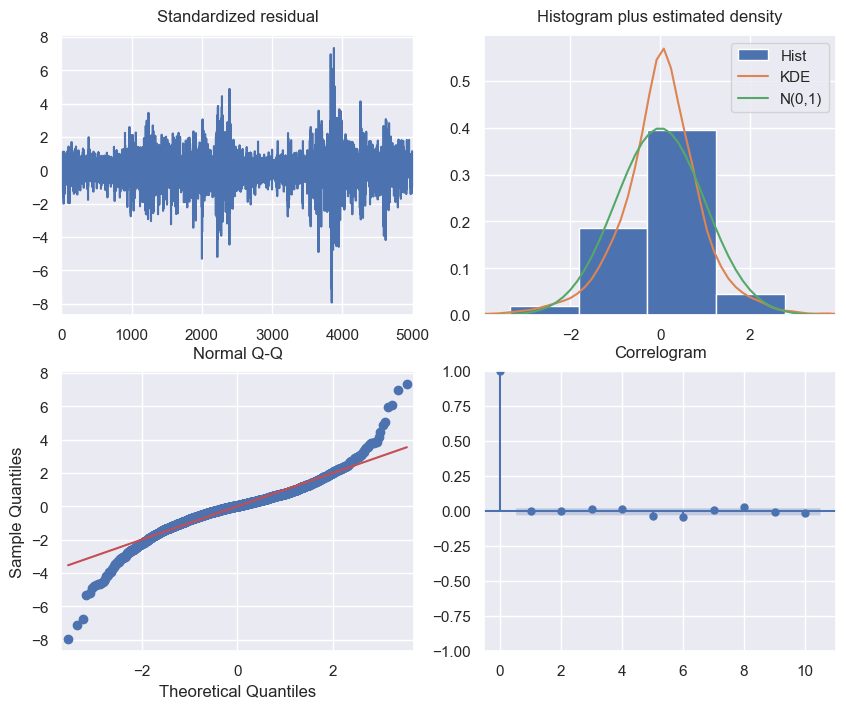

In [560]:
model_auto_arima.plot_diagnostics(figsize=(10,8))
plt.show()

#### Analysing the Residuals

We want error tests to resemble white noise (random)
1. Stationary - DF test
2. Most of the coefficients to be non-significant - ACF plot
3. Look random when we plot them
4. Mean close to 0 to minimise error magnitude and variance close to 0 so that prediction is always close to the true value.

In [561]:
df_train['res_arima'] = model_auto_arima.resid()
print(df_train.res_arima.mean())
print(df_train.res_arima.var())
sts.adfuller(df_train.res_arima)

0.0001446581333466077
0.00013649278940752477


(-12.580028332665908,
 1.9194722706045234e-23,
 32,
 4981,
 {'1%': -3.4316635260404795,
  '5%': -2.8621204359855366,
  '10%': -2.567078966862675},
 -30180.5421127933)

We want most of ACT of Residuals to be non-significant. The effects of returns and errors tend to diminish over time. The further back in time we go, the less relevant the values are.

Text(0.5, 1.0, 'ACF of Residuals for ARIMA')

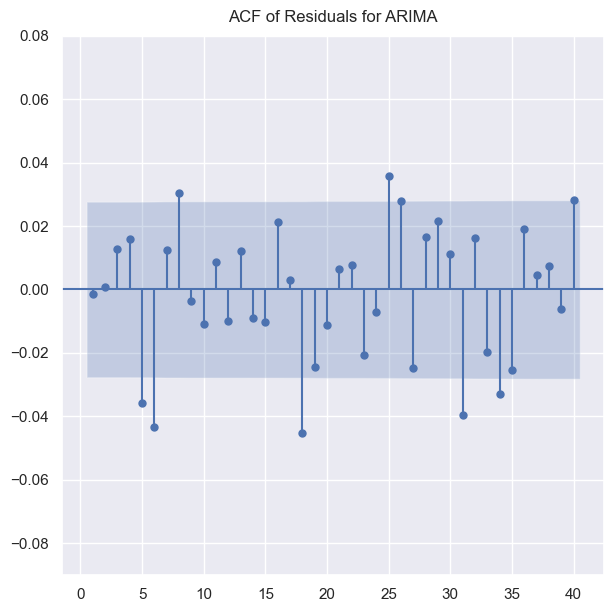

In [562]:
sgt.plot_acf(df_train.res_arima, lags=40, zero=False)
plt.ylim(-0.09,0.08)
plt.title('ACF of Residuals for ARIMA')

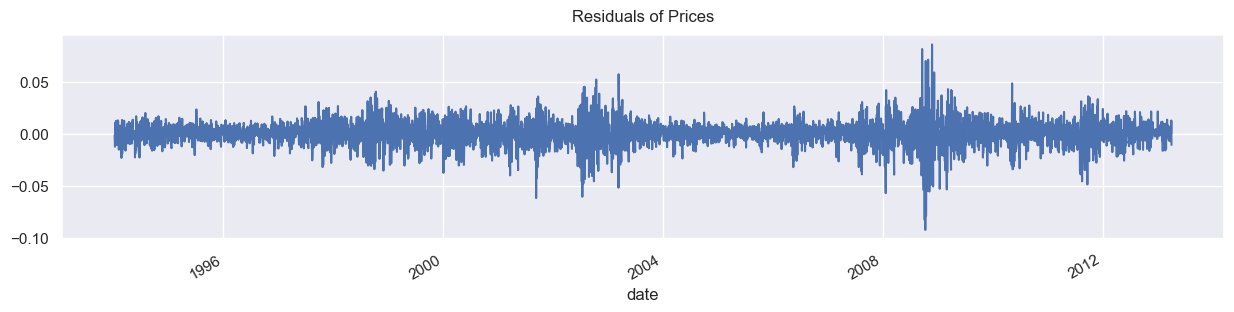

In [563]:
df_train.res_arima.plot(figsize=(15,3))
plt.title('Residuals of Prices')
plt.show()

#### Forecast/Rolling window

In [564]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

In [581]:
history = [x for x in df_train.returns]
predictions = []

start_date = '2014-07-15'
end_date = '2015-01-01'

test_times = df_test.index[:100]

for t in test_times:
    model = ARIMA(history, order=(1,0,3))
    output = model.fit().forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = df_test.returns[t]
    history.append(obs)

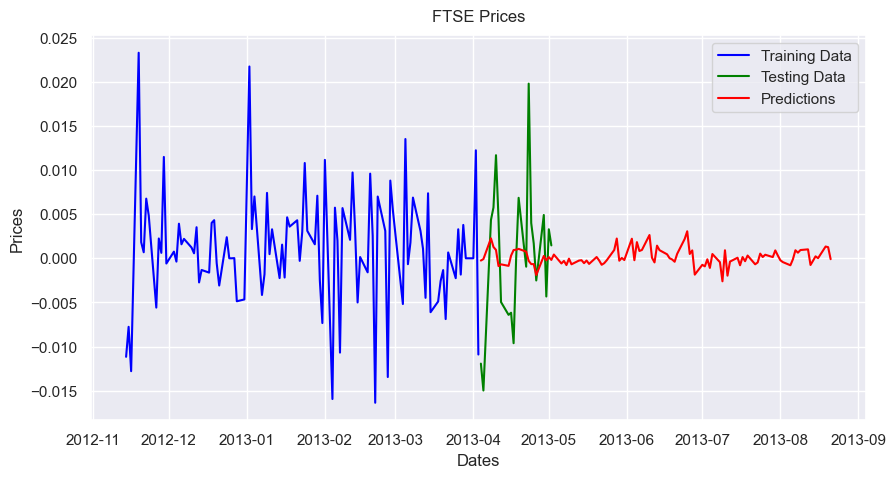

In [586]:
plt.figure(figsize=(10,5))
plt.title('FTSE Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_train.returns[-100:], 'blue', label='Training Data')
plt.plot(df_test.returns[:21], 'green', label='Testing Data')
plt.plot(test_times, predictions, 'red', label='Predictions')
plt.legend()

In [588]:
error = mean_squared_error(df_test.returns[:100], predictions)
print('Testing Mean Squared Error %.3f' %error)

error2 = smape_kun(df_test.returns[:100], predictions)
print('Symmetric mean absolute percentage error: %.3f' %error2)

Testing Mean Squared Error 0.000
Symmetric mean absolute percentage error: 175.281


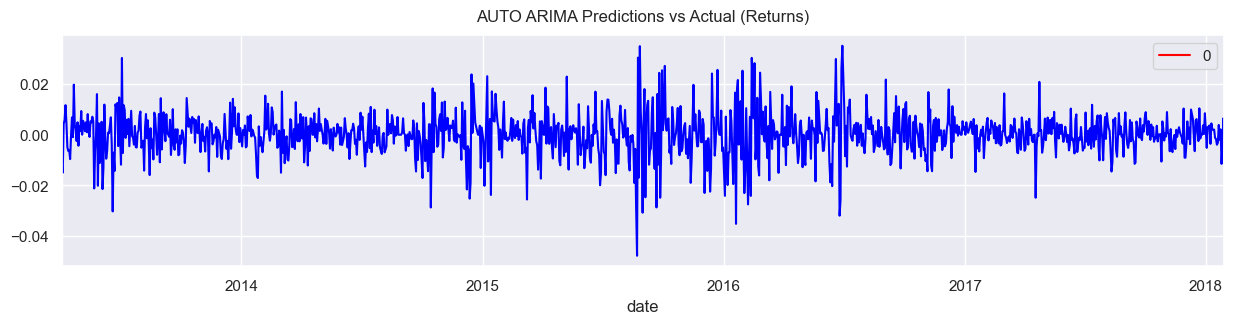

In [598]:
start_date = '2014-07-15'
end_date = '2015-01-01'
df_auto_pred = pd.DataFrame(model_auto_arima.predict(n_periods = len(df_test[start_date:end_date])), index = df_test[start_date:end_date].index)

df_auto_pred.plot(figsize=(15,3), color='red')
df_test.returns.plot(color='blue')
plt.title('AUTO ARIMA Predictions vs Actual (Returns)')
plt.show()

### SARIMA

Better for modelling non-stationary data - e.g. prices

In [600]:
# Seasonal - fit stepwise auto-ARIMA
model_auto_sarima = pm.auto_arima(df_train.returns, m=5, seasonal=True)

In [603]:
model_auto_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 5014
Model:             SARIMAX(2, 0, 3)x(0, 0, [1], 5)   Log Likelihood               15202.369
Date:                             Sat, 06 May 2023   AIC                         -30390.738
Time:                                     15:56:29   BIC                         -30345.098
Sample:                                          0   HQIC                        -30374.744
                                            - 5014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3707      0.106     -3.485      0.000      -0.579      -0.162
ar.L2         -0.1832      0.117     -1.563      0.118      -0.413       0.046
ma.L1          0.3478      0.106      3.295      0.001       0.141       0.555
ma.L2          0.1267      0.119      1.068      0.286      -0.106       0.359
ma.L3         -0.1028      0.009    -11.296      0.000      -0.121      -0.085
ma.S.L5       -0.0507      0.014     -3.537      0.000      -0.079      -0.023
sigma2         0.0001   1.47e-06     92.668      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6569.51
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

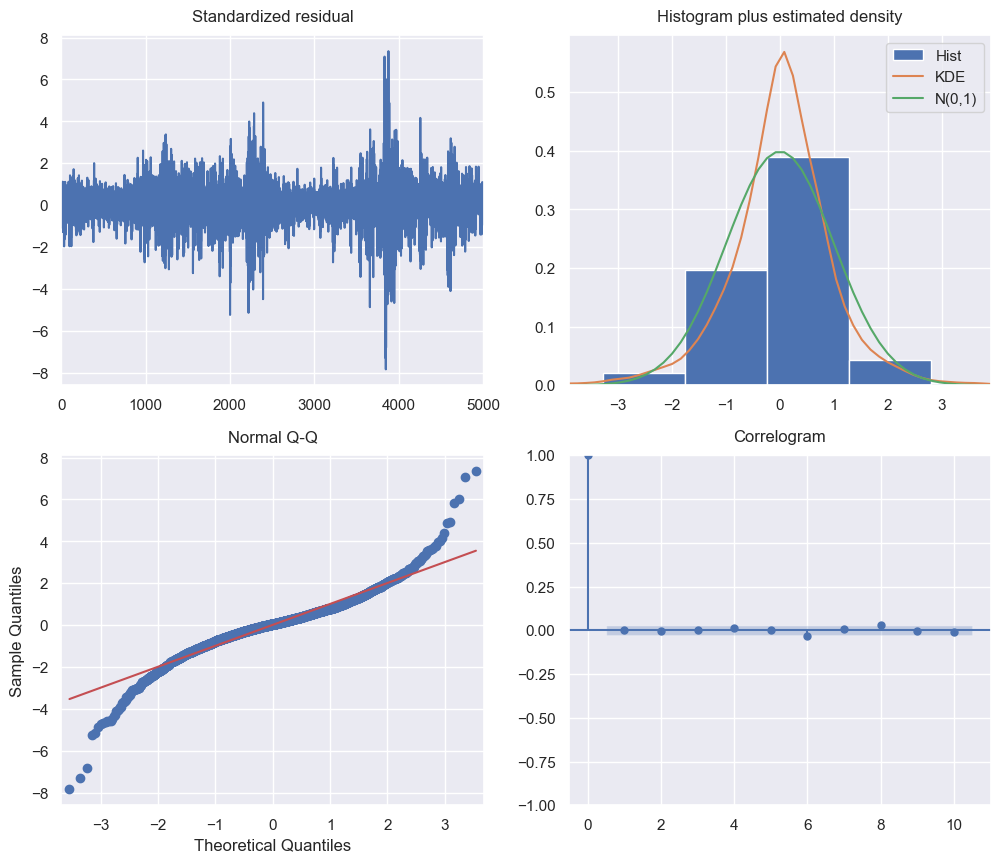

In [604]:
model_auto_sarima.plot_diagnostics(figsize=(12,10))
plt.show()

In [605]:
df_train['res_sarima'] = model_auto_sarima.resid()
print(df_train.res_sarima.mean())
print(df_train.res_sarima.var())
sts.adfuller(df_train.res_sarima)

0.0001480744756494524
0.0001361420424487966


(-70.79882441154065,
 0.0,
 0,
 5013,
 {'1%': -3.431655136974821,
  '5%': -2.8621167297421373,
  '10%': -2.567076993884522},
 -30182.998710435422)

Text(0.5, 1.0, 'ACF of Residuals for SARIMA')

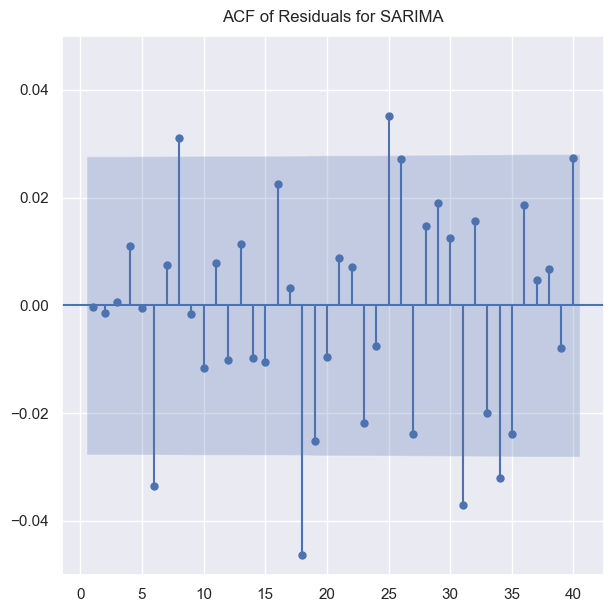

In [606]:
sgt.plot_acf(df_train.res_sarima, lags=40, zero=False)
plt.ylim(-0.05,0.05)
plt.title('ACF of Residuals for SARIMA')

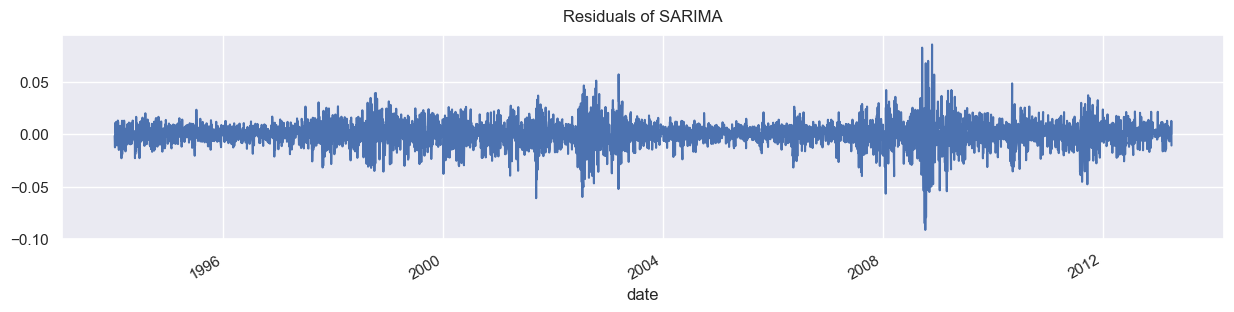

In [607]:
df_train.res_sarima.plot(figsize=(15,3))
plt.title('Residuals of SARIMA')
plt.show()

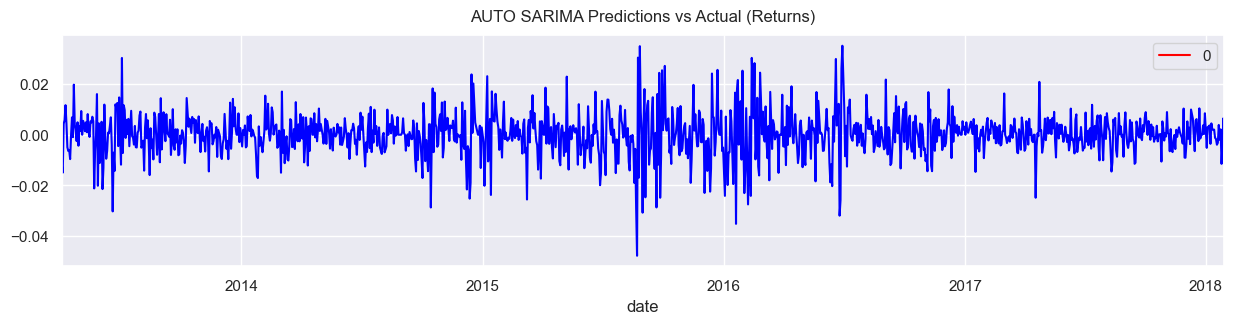

In [609]:
start_date = '2014-07-15'
end_date = '2015-01-01'
df_auto_pred = pd.DataFrame(model_auto_sarima.predict(n_periods = len(df_test[start_date:end_date])),
                            index = df_test[start_date:end_date].index)

df_auto_pred.plot(figsize=(15,3), color='red')
df_test.ret_ftse.plot(color='blue')
plt.title('AUTO SARIMA Predictions vs Actual (Returns)')
plt.show()

### ARIMAX

Exogenous variables. Only for predictions, not for forecastst

In [ ]:
# seasonal order m -> 5 business days
model_auto_arimax = pm.auto_arima(df_comp.ret_ftse[1:], df_comp[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], m=5)

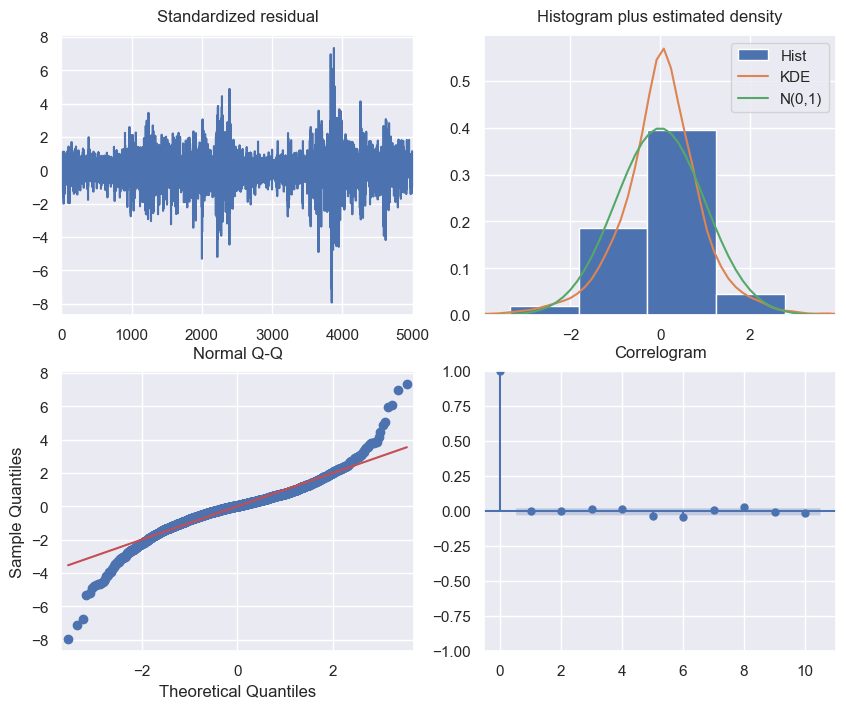

In [ ]:
model_auto_arimax.plot_diagnostics(figsize=(10,8))
plt.show()

In [ ]:
df_train['res_arimax'] = model_auto_arimax.resid()
print(df_train.res_arimax.mean())
print(df_train.res_arimax.var())
sts.adfuller(df_train.res_arimax)

0.0001446581333466077
0.00013649278940752477


(-12.580028332665908,
 1.9194722706045234e-23,
 32,
 4981,
 {'1%': -3.4316635260404795,
  '5%': -2.8621204359855366,
  '10%': -2.567078966862675},
 -30180.5421127933)

We want most of ACT of Residuals to be non-significant. The effects of returns and errors tend to diminish over time. The further back in time we go, the less relevant the values are.

Text(0.5, 1.0, 'ACF of Residuals for ARIMA')

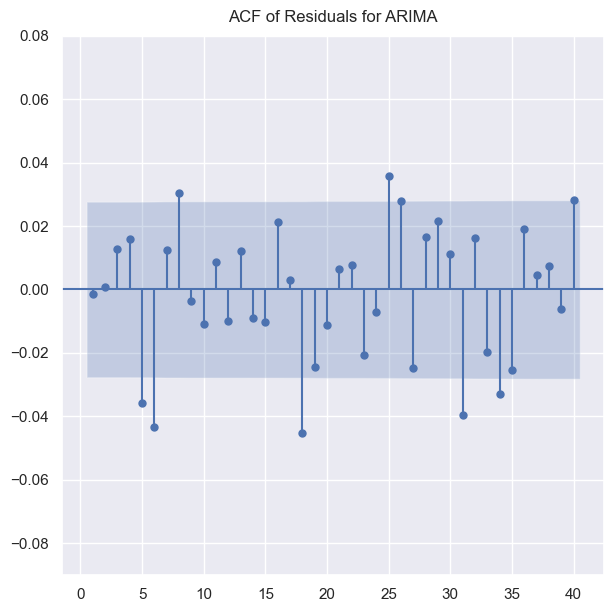

In [ ]:
sgt.plot_acf(df_train.res_arimax, lags=40, zero=False)
plt.ylim(-0.09,0.08)
plt.title('ACF of Residuals for ARIMAX')

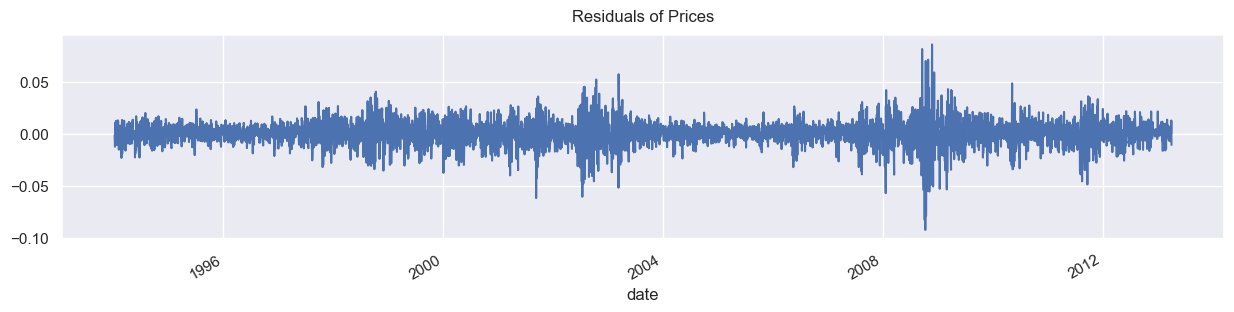

In [ ]:
df_train.res_arimax.plot(figsize=(15,3))
plt.title('Residuals of Prices')
plt.show()

### SARIMAX

(p, d, q)(P, D, Q, s)\
s: number of periods nedded to pass before the tendency reappears. s = 1 -> NO seasonality. Interested in every 's-th' value. e.g 5 - t-5, t-10, t-15, etc

In [612]:
model_auto_sarimax = pm.auto_arima(df.ret_ftse[1:], X= df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:])

In [615]:
model_auto_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6267
Model:               SARIMAX(2, 0, 3)   Log Likelihood               22511.497
Date:                Sat, 06 May 2023   AIC                         -45004.994
Time:                        16:00:56   BIC                         -44944.307
Sample:                             0   HQIC                        -44983.965
                               - 6267                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ret_spx        0.1204      0.006     21.777      0.000       0.110       0.131
ret_dax        0.5387      0.005    113.847      0.000       0.529       0.548
ret_nikkei     0.0746      0.004     17.655      0.000       0.066       0.083
ar.L1         -0.1686      0.136     -1.239      0.215      -0.435       0.098
ar.L2          0.2392      0.144      1.659      0.097      -0.043       0.522
ma.L1          0.0579      0.136      0.424      0.671      -0.210       0.325
ma.L2         -0.2646      0.139     -1.906      0.057      -0.537       0.007
ma.L3         -0.0302      0.020     -1.510      0.131      -0.069       0.009
sigma2      4.438e-05    4.5e-07     98.593      0.000    4.35e-05    4.53e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):             12735.36
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

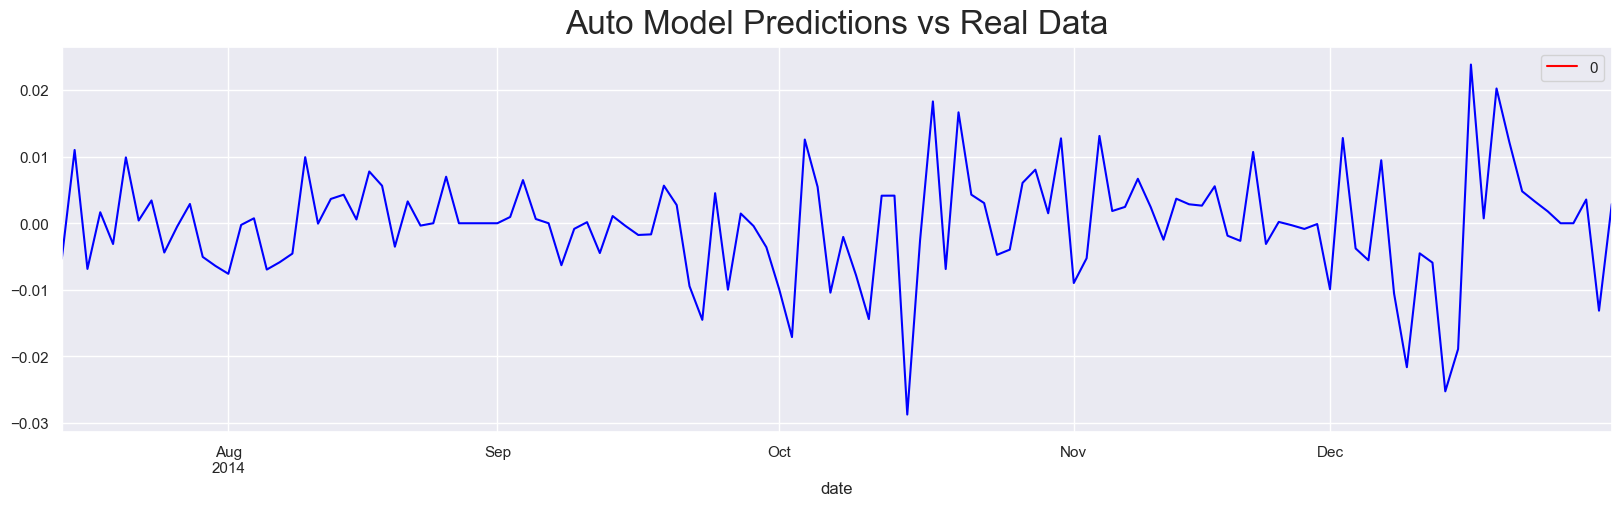

In [613]:
df_auto_pred = pd.DataFrame(model_auto_sarimax.predict(n_periods = len(df_test[start_date:end_date]), X=df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date]),index = df_test[start_date:end_date].index)

df_auto_pred.plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

## Machine Learning

### Gradient Boosting

In [ ]:
def window_input(window_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df = data.copy()
    
    i = 1
    while i < window_length:
        df[f'x_{i}'] = df['co2'].shift(-i)
        i = i + 1
        
    if i == window_length:
        df['y'] = df['co2'].shift(-i)
        
    # Drop rows where there is a NaN
    df = df.dropna(axis=0)
        
    return df

In [ ]:
new_df = window_input(5, data)
from sklearn.model_selection import train_test_split

X = new_df[['co2', 'x_1', 'x_2', 'x_3', 'x_4']].values
y = new_df['y'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

In [ ]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true))*100,2)

In [ ]:
gbr_5 = GradientBoostingRegressor(random_state=42)

gbr_5.fit(X_train, y_train.ravel())

gbr_5_pred = gbr_5.predict(X_test)
gbr_5_mape = mape(y_test, gbr_5_pred)



In [ ]:
def window_input_output(input_length: int, output_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df = data.copy()
    
    i = 1
    while i < input_length:
        df[f'x_{i}'] = df['co2'].shift(-i)
        i = i + 1
        
    j = 0
    while j < output_length:
        df[f'y_{j}'] = df['co2'].shift(-output_length-j)
        j = j + 1
        
    df = df.dropna(axis=0)
    
    return df

In [ ]:
seq_df = window_input_output(26, 26, data)  #26 weeks
X_cols = [col for col in seq_df.columns if col.startswith('x')]

X_cols.insert(0, 'co2')

y_cols = [col for col in seq_df.columns if col.startswith('y')]
X_train = seq_df[X_cols][:-2].values
y_train = seq_df[y_cols][:-2].values

X_test = seq_df[X_cols][-2:].values
y_test = seq_df[y_cols][-2:].values

In [ ]:
from sklearn.multioutput import RegressorChain

gbr_seq = GradientBoostingRegressor(random_state=42)

chained_gbr = RegressorChain(gbr_seq)

chained_gbr.fit(X_train, y_train)

gbr_seq_preds = chained_gbr.predict(X_test)

mape_gbr_seq = mape(gbr_seq_preds.reshape(1, -1), y_test.reshape(1, -1))

### LSTM

Min-Max Scaler

In [668]:
scaler = MinMaxScaler(feature_range=(0,1))

# scaled_data = scaler.fit_transform([df_comp.returns.iloc[1:].values])
len_train_data = int(len(df_comp)*0.8)
train_data = df_comp.returns[1:len_train_data]
valid_data = df_comp.returns[len_train_data:]

x_train_data, y_train_data = [], []
df_comp = df_comp[1:]
for i in range(60, len(train_data)):
    # take 60 previous observations as x
    x_train_data.append(df_comp.returns[i-60:i].values)
    # take last observation in the 60 window as y
    y_train_data.append(df_comp.returns[i])


In [669]:
x_train_data = np.array(x_train_data)
y_train_data = np.array(y_train_data)

LSTM Model

LSTM models work great when making predictions based on time-series datasets.\
Units: dimensionality of output space\
Return_sequences: whether to return the last output in the output sequence, or the full sequence\

In [673]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=50, input_shape=(np.shape(x_train_data)[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

Train and Test Data

In [676]:
# adam: stochastic gradient descent method
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=10,batch_size=1,verbose=2)

Epoch 1/10
4954/4954 - 101s - loss: 1.4527e-04 - 101s/epoch - 20ms/step
Epoch 2/10
4954/4954 - 97s - loss: 1.4583e-04 - 97s/epoch - 20ms/step
Epoch 3/10
4954/4954 - 85s - loss: 1.4504e-04 - 85s/epoch - 17ms/step
Epoch 4/10
4954/4954 - 90s - loss: 1.4405e-04 - 90s/epoch - 18ms/step
Epoch 5/10
4954/4954 - 134s - loss: 1.4406e-04 - 134s/epoch - 27ms/step
Epoch 6/10
4954/4954 - 135s - loss: 1.4586e-04 - 135s/epoch - 27ms/step
Epoch 7/10
4954/4954 - 102s - loss: 1.4533e-04 - 102s/epoch - 21ms/step
Epoch 8/10
4954/4954 - 104s - loss: 1.4492e-04 - 104s/epoch - 21ms/step
Epoch 9/10
4954/4954 - 113s - loss: 1.4498e-04 - 113s/epoch - 23ms/step
Epoch 10/10
4954/4954 - 140s - loss: 1.4488e-04 - 140s/epoch - 28ms/step


Prediction Function

In [718]:
model_data = df_comp.returns[len(df_comp)-len(valid_data)-60:].values # 250 - 50 - 60 -> 140:250
model_data = model_data.reshape(-1,1)

In [719]:
model_data.shape

(1314, 1)

In [724]:
X_test = []
for i in range(len(train_data), len(df_comp)):
    X_test.append(df_comp.returns[i-60:i].values) # for the last 50 values, get their 60 previous window

X_test
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [725]:
X_test.shape

(1254, 60, 1)

In [726]:
predicted_stock_price = lstm_model.predict(X_test)
# predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

40/40 [==============================] - 0s 10ms/step


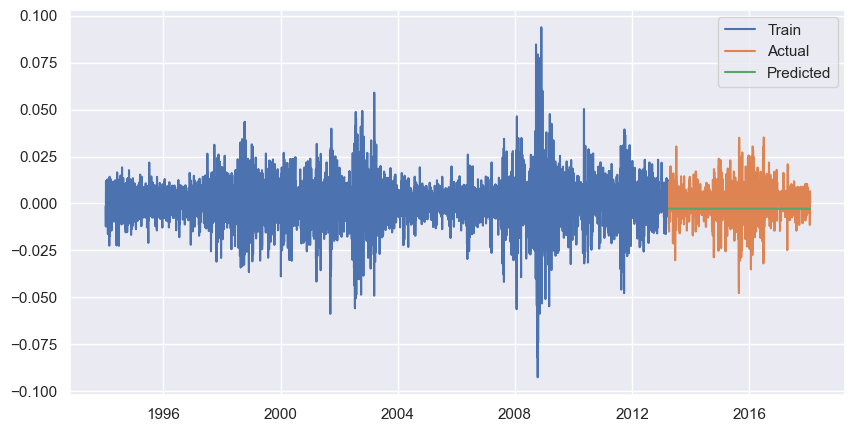

In [727]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(df_train.returns)
plt.plot(valid_data)
plt.plot(valid_data.index, predicted_stock_price)
plt.legend(['Train','Actual', 'Predicted'])

## Volatility

Magnitude of residuals: how off our predictions are.\
Lower variance -> Stability -> Low risk -> Safety\
Trnasform data by squaring the values, penalising high diffenreces between true values and predictions more. Increases the importance of big unpredicted shocks.

In [728]:
df['sq_returns'] = df.returns.mul(df.returns)

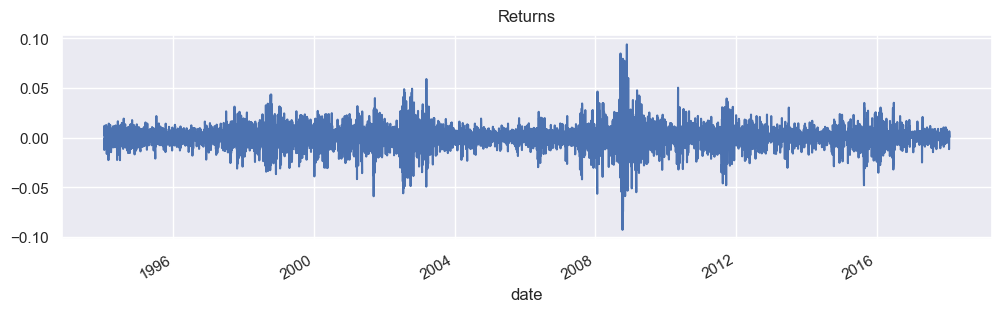

In [729]:
df.returns.plot(figsize=(12,3))
plt.title('Returns')
plt.show()

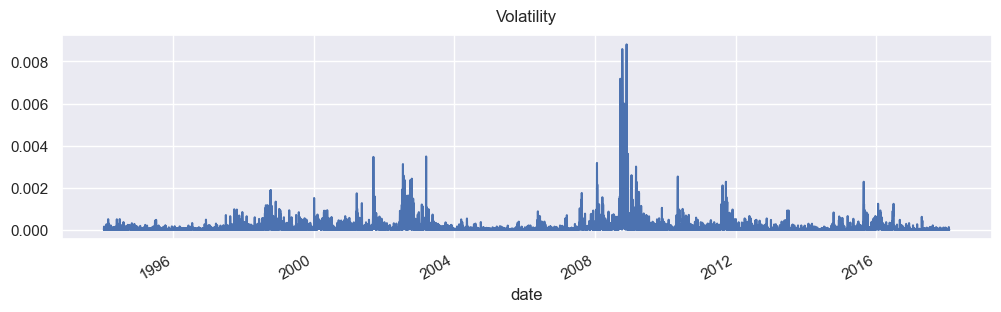

In [730]:
df.sq_returns.plot(figsize=(12,3))
plt.title('Volatility')
plt.show()

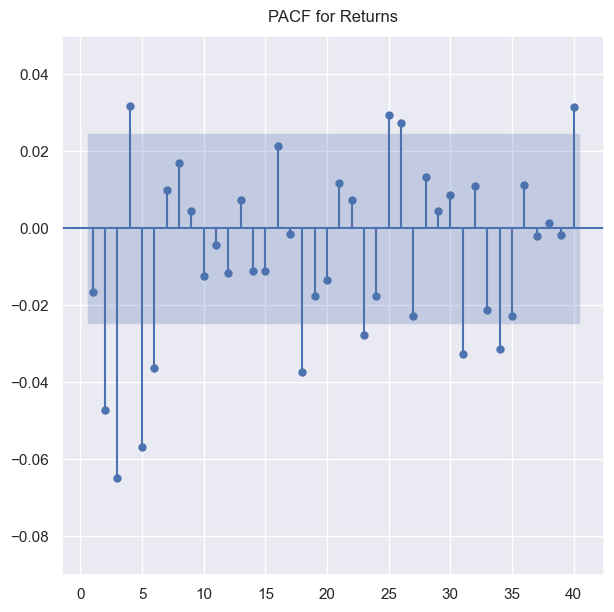

In [731]:
sgt.plot_pacf(df.returns[1:], lags=40, alpha = 0.05, zero=False, method=('ols'))
plt.title('PACF for Returns')
plt.ylim(-0.09,0.05)
plt.show()

High positive significant coefficients in the first few lags.\
There tend to be short-term trends in variance.\
Clustering:
- high variation -> high variation
- low variation -> low variation

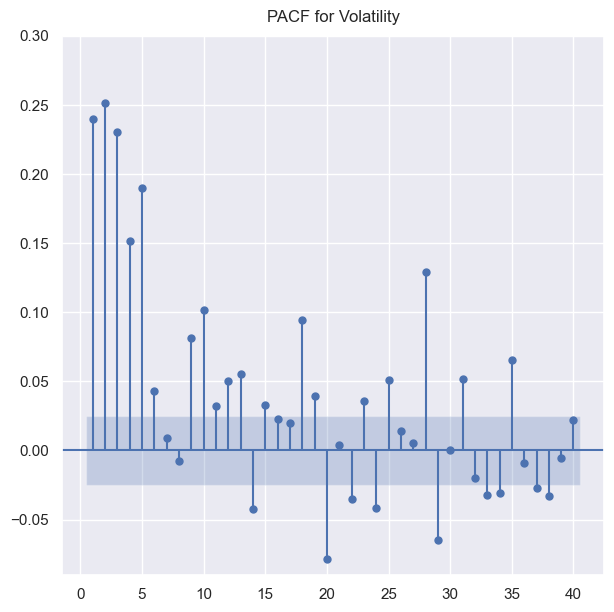

In [732]:
sgt.plot_pacf(df.sq_returns[1:], lags=40, alpha = 0.05, zero=False, method=('ols'))
plt.title('PACF for Volatility')
plt.ylim(-0.09,0.3)
plt.show()

### GARCH

ARCH can only be used to predict future variance rather than future returns

GARCH(1,1) is the best model for measuring volatility of returns - no need to rely on overly complicated models.
- Omega: constant
- Alpha: coefficients for squared residuals
- Beta: coefficients for the conditional variance from last period

p: ARCH order, past squared residuals (equivalent to MA in ARMA)\
q: GARCH order, past conditional variances (equivalent to AR in ARMA)

mean: 'Constant' -> serially uncorrelated mean - mean model doesn't rely on past values or errors

Only GARCH(1,1)
- All the effects of the conditional variance 2 days ago will be contained in the conditional variance of yesterday
- No need to include more than 1 GARCH component

In [733]:
model_garch_1_1 = arch_model(df.returns[1:], mean='Constant', vol='GARCH', p = 1, q = 1)
results_garch_1_1 = model_garch_1_1.fit(update_freq=5) 
results_garch_1_1.summary()

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 37646.809028863325
            Iterations: 4
            Function evaluations: 49
            Gradient evaluations: 4


/Users/mcardonasanchez/Desktop/Online Courses/The-Data-Science-Course-2021-All-Resources/ds-env/lib/python3.9/site-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -37646.8
Distribution:                  Normal   AIC:                           75301.6
Method:            Maximum Likelihood   BIC:                           75328.6
                                        No. Observations:                 6267
Date:                Sat, May 06 2023   Df Residuals:                     6266
Time:                        17:04:12   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.8781     15.894      0.118      0.906 [-29.273, 33.029]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.5004e-06  5.991e-04  4.174e-03      0.997 [-1.172e-03,1.177e-03]
alpha[1]       0.1000      0.700      0.143      0.886      [ -1.272,  1.472]
beta[1]        0.8800      0.937      0.939      0.348      [ -0.957,  2.717]
=============================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Inequality constraints incompatible.
See convergence_flag.

"""